<a href="https://colab.research.google.com/github/cloudmrhub/mroptimum-tools/blob/main/mroptimum_tools.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MR Optimum tools Installation

In [ ]:
!pip install git+https://github.com/cloudmrhub/mroptimum-tools

  Cloning https://github.com/cloudmrhub/mroptimum-tools to /tmp/pip-req-build-gescej2g
  Running command git clone --filter=blob:none --quiet https://github.com/cloudmrhub/mroptimum-tools /tmp/pip-req-build-gescej2g
  Resolved https://github.com/cloudmrhub/mroptimum-tools to commit 9ecc6b713f4820cf994fe4cd9dce32fa6f2fc416
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/cloudmrhub/cloudmr-tools.git to /tmp/pip-install-_06xykd7/cmtools_2ceda9d785fd476b8b1b23f9ab0a2340
  Running command git clone --filter=blob:none --quiet https://github.com/cloudmrhub/cloudmr-tools.git /tmp/pip-install-_06xykd7/cmtools_2ceda9d785fd476b8b1b23f9ab0a2340
  Resolved https://github.com/cloudmrhub/cloudmr-tools.git to commit ea9160e15c3c4d0a68966c5bd7518dcca87efa19
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... don

In [ ]:
# Load the data available for testing
from mrotools.mro import mroArrayCombiningRSS,mroArrayCombiningB1,mroArrayCombiningSENSE,mroPseudoMultipleReplicas


from pynico_eros_montin import pynico as pn

import numpy as np
import matplotlib.pyplot as plt

import cmtools
import os
import importlib.util

spec = importlib.util.find_spec('cmtools')
print(spec.submodule_search_locations)
if spec is not None:
    package_path = spec.submodule_search_locations[0]
    package_path=os.path.join(package_path,'testdata.pkl')
else:
    print("cmtools module not found")

a=pn.Pathable(package_path)
A=a.readPkl()

S=A[0]["signal"]
N=A[0]["noise"]


<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


['/usr/local/lib/python3.10/dist-packages/cmtools']


calculateCoilsSensitivityMask2D espirit


/usr/local/lib/python3.10/dist-packages/cmtools/cm2D.py:340: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  snr[irow,icol] = np.abs(np.sqrt(2*(A @ B)))


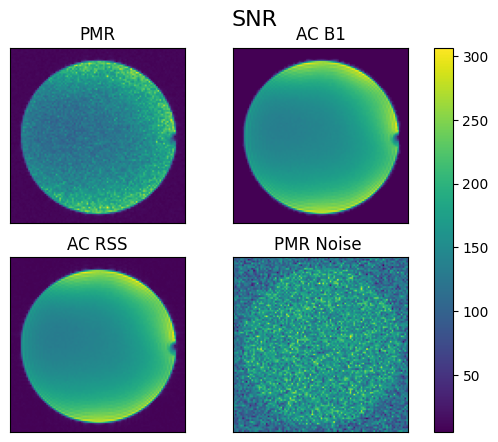

In [ ]:

from cmtools.cm2D import cm2DReconRSS


L2=mroPseudoMultipleReplicas()
L=cm2DReconRSS()
L2.numberOfReplicas=50
L.setNoiseKSpace(N)
L.setSignalKSpace(S)
L2.reconstructor=L

plt.subplot(221)
plt.imshow(np.abs(L2.getOutput()))
plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
plt.title('PMR')

# from mrotools.mro import mroGeneralizedPseudoMultipleReplicas
# R2=mroGeneralizedPseudoMultipleReplicas()
# R=cm2DReconRSS()
# R2.numberOfReplicas=5
# R2.boxSize=10
# R.setNoiseKSpace(N)
# R.setSignalKSpace(S)
# R2.reconstructor=R


R2=mroArrayCombiningB1()
R2.setNoiseKSpace(N)
R2.setSignalKSpace(S)
R2.setReferenceKSpace(S)
R2.setMaskCoilSensitivityMatrixBasedOnEspirit()
plt.subplot(222)
plt.imshow(np.abs(R2.getOutput()))
plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
plt.title('AC B1')


R=mroArrayCombiningRSS()
R.setNoiseKSpace(N)
R.setSignalKSpace(S)
plt.subplot(223)
plt.imshow(np.abs(R.getOutput()))
plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
plt.title('AC RSS')


plt.subplot(224)
plt.imshow(L2.getSNRDenumerator())
plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
plt.title('PMR Noise ')
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
plt.colorbar(plt.gcf().axes[0].images[0], ax=plt.gcf().axes)

plt.suptitle("SNR", fontsize=16)

plt.show()

/usr/local/lib/python3.10/dist-packages/cmtools/cm.py:328: ComplexWarning: Casting complex values to real discards the imaginary part
  coeff[itemp,jtemp] = cov[itemp,jtemp]/np.sqrt(cov[itemp,itemp]*cov[jtemp,jtemp])


calculateCoilsSensitivityMask2D reference 
calculateCoilsSensitivityMask2D reference 


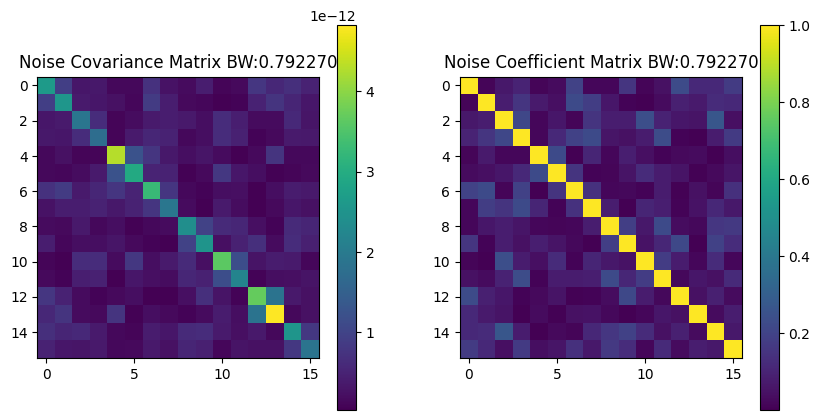

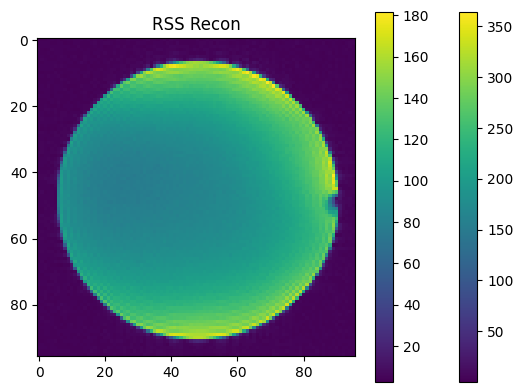

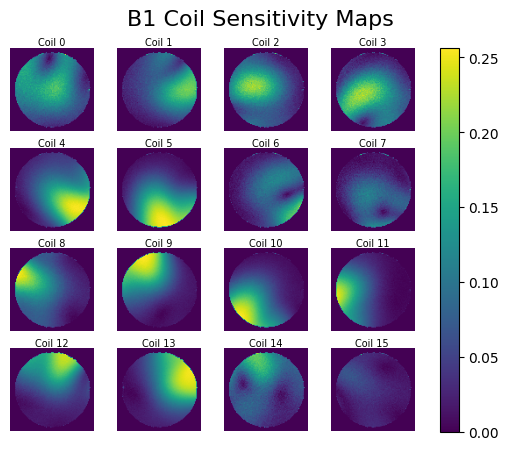

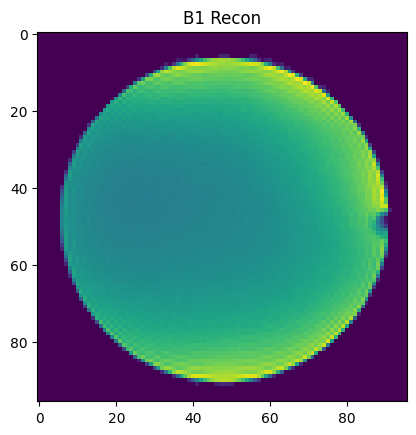

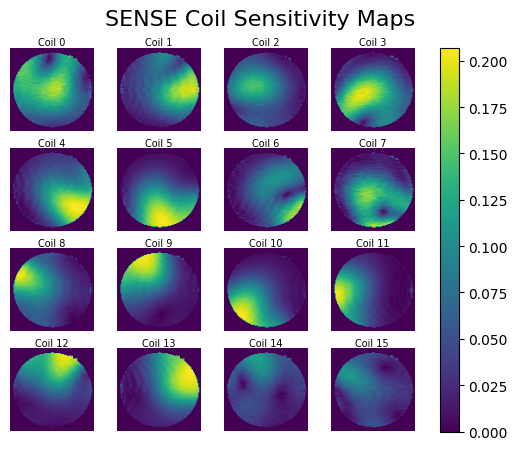

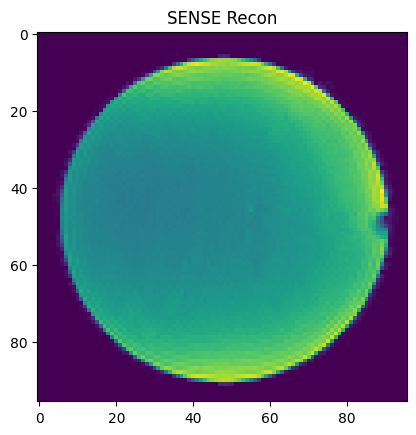

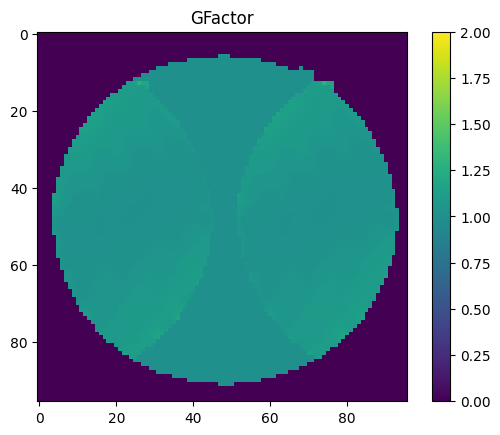

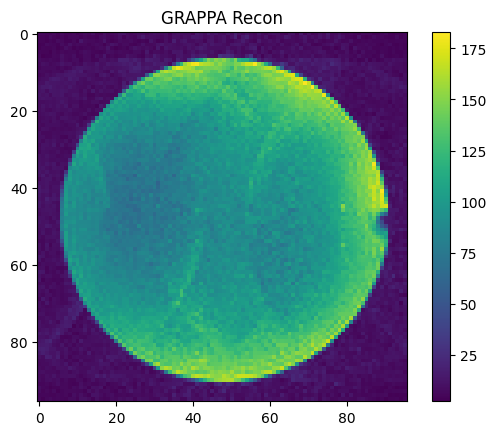

In [ ]:
from cmtools.cm2D import cm2DReconRSS, cm2DReconB1,cm2DReconSENSE,cm2DGFactorSENSE,cm2DReconGRAPPA
import cmtools.cm as cm


L=cm2DReconRSS()
L.setSignalKSpace(S)
L.setNoiseKSpace(N)

NBW=L.getNoiseBandWidth()

nc2=L.getNoiseCovariance()
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(np.abs(nc2))
plt.colorbar()
plt.title(f'Noise Covariance Matrix BW:{NBW:03f}')

plt.subplot(122)
plt.imshow(np.abs(L.getNoiseCovarianceCoefficients()))
plt.colorbar()
plt.title(f'Noise Coefficient Matrix BW:{NBW:03f}')


p=L.getPrewhitenedSignal()
plt.figure()
plt.imshow(np.abs(p[:,:,0]))
plt.colorbar()
plt.title('Prewhitened Kspace First Coil')

im=L.getOutput()

import matplotlib.pyplot as plt

plt.imshow(im)
plt.colorbar()
plt.title('RSS Recon')

L=cm2DReconB1()
L.setSignalKSpace(S)
L.setNoiseKSpace(N)
L.setReferenceKSpace(S)
L.prepareCoilSensitivityMatrixPlot(title='B1 Coil Sensitivity Maps')
plt.figure()
plt.imshow(np.abs(L.getOutput()))
plt.title('B1 Recon')



# acceleration frequency and phase
FA=1
PA=2
# autocalibrationlines
ACL=20
L=cm2DReconSENSE()
L.setAcceleration([FA,PA])
US,REF=cm.mimicAcceleration2D(S,[FA,PA],ACL=[np.nan,ACL])

L.setSignalKSpace(US)
L.setNoiseKSpace(N)
L.setReferenceKSpace(REF)
L.setAutocalibrationLines(ACL)

L.prepareCoilSensitivityMatrixPlot(title='SENSE Coil Sensitivity Maps')

plt.figure()
plt.imshow(np.abs(L.getOutput()))
plt.title('SENSE Recon')



# transform in Kellman!!!
L.__class__=cm2DGFactorSENSE
plt.figure()
plt.imshow(np.abs(L.getOutput()),vmin=0,vmax=2)
plt.colorbar()
plt.title('GFactor')



FA=1
PA=4
ACLF=20
ACLP=20
GK=[2,5]

US,REF=cm.mimicAcceleration2D(S,[FA,PA],[ACLF,ACLP])
L=cm2DReconGRAPPA()
L.setSignalKSpace(US)
L.setAcceleration([FA,PA])
L.setAutocalibrationLines([ACLF,ACLP])
L.setNoiseKSpace(N)
L.setGRAPPAKernel(GK)
L.setReferenceKSpace(REF)

plt.figure()
plt.imshow(np.abs(L.getOutput()))
plt.colorbar()
plt.title('GRAPPA Recon')
plt.show()